#### Testing performances in k-dimensional case

In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from utility import gen_data_kd, BH
from prediction_model import OracleRegressorkd
from sklearn.metrics import r2_score, accuracy_score
from tqdm import tqdm

##### Purposed method - using a dist based nonconformity score

In [38]:
def purp(setting, reg, q, k, order=0.5, itr=1000, plot=True):
    fdps_purp = []
    powers_purp = []

    def dist(Y):
        Y = np.maximum(Y, 0)
        return np.linalg.norm(Y, axis=1, ord=order)

    for i_itr in tqdm(range(itr)):
        Xtrain, Ytrain = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)
        Xcalib, Ycalib = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)
        Xtest, Ytest = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)

        if reg == 'rf':
            rf = RandomForestRegressor(n_estimators=100, max_depth=50, max_features=10)
        elif reg == 'oracle':
            rf = OracleRegressorkd(setting) 
        rf.fit(Xtrain, Ytrain)

        Ypred_calib = rf.predict(Xcalib)
            
        # calibration 
        calib_scores_2clip = 1000 * (np.all(Ycalib > 0, axis=1)) - dist(Ypred_calib)                          # BH_clip (with M = 1000)

        Ypred = rf.predict(Xtest) 
        test_scores = - dist(Ypred)

        r_sq = r2_score(Ytest, Ypred)

        true_null = np.sum(np.all(Ytest > 0, axis=1))
        # print(true_null)

        # use clipped scores
        BH_2clip = BH(calib_scores_2clip, test_scores, q )
        if len(BH_2clip) == 0:
            BH_2clip_fdp = 0
            BH_2clip_power = 0
        else:
            BH_2clip_fdp = np.sum(np.any(Ytest[BH_2clip] <= 0, axis=1)) / len(BH_2clip)
            BH_2clip_power = np.sum(np.all(Ytest[BH_2clip] > 0, axis=1)) / true_null if true_null != 0 else 0
        fdps_purp.append(BH_2clip_fdp)
        powers_purp.append(BH_2clip_power)

    # plot
    if plot:
        fig, axs = plt.subplots(ncols = 2, figsize=(8, 6))

        fig.suptitle(f"Purposed (l{str(order)}), setting {setting}, {reg} regressor, \n q = {q}, k = {k}, averaged over {itr} times")
        axs[0].boxplot(fdps_purp, showmeans=True)
        axs[0].set_title("FDP")
        axs[0].text(1.1, np.mean(fdps_purp), f"{np.mean(fdps_purp):.4f}")
        axs[1].boxplot(powers_purp, showmeans=True)
        axs[1].set_title("Power")
        axs[1].text(1.1, np.mean(powers_purp), f"{np.mean(powers_purp):.4f}")
        fig.tight_layout()
        plt.show()
    return fdps_purp, powers_purp

100%|██████████| 1000/1000 [11:28<00:00,  1.45it/s]


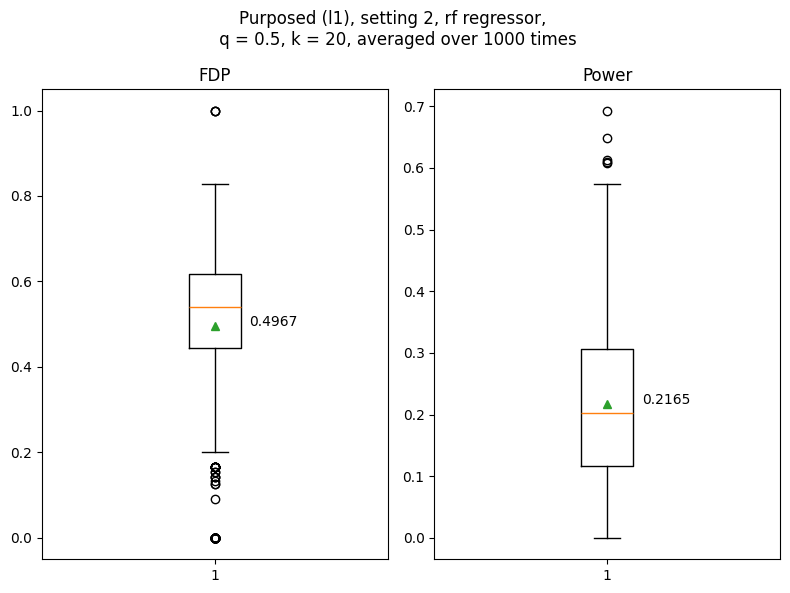

In [49]:
fdps_purp, powers_purp = purp(2, 'rf', 0.5, 20, 1)

100%|██████████| 1000/1000 [11:28<00:00,  1.45it/s]


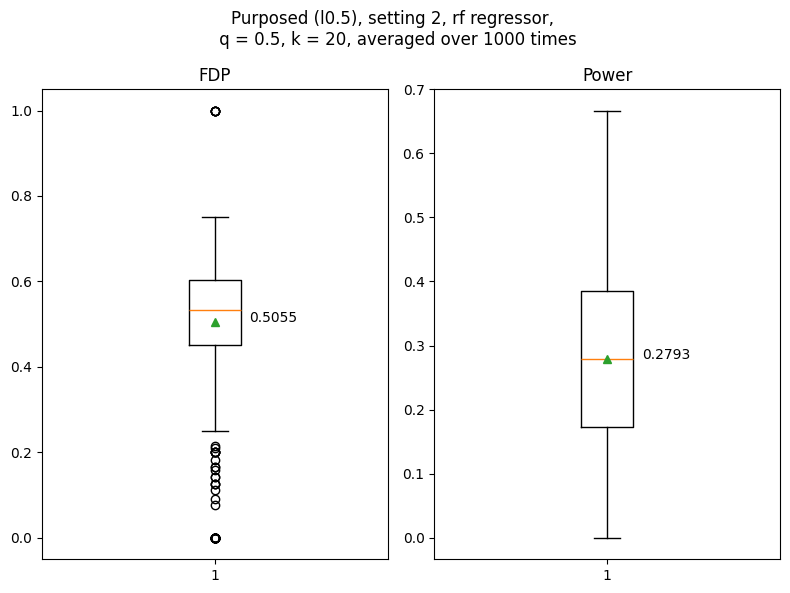

In [50]:
fdps_purp, powers_purp = purp(2, 'rf', 0.5, 20, 0.5)

##### Alternative 1 - turn in to 1d 0/1 regression problem

In [41]:
def alt1(setting, reg, q, k, itr=1000, plot=True):
    fdps_alt1 = []
    powers_alt1 = []

    for i_itr in tqdm(range(itr)):
        Xtrain, Ytrain = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)
        Xcalib, Ycalib = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)
        Xtest, Ytest = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)

        Ytrain = np.all(Ytrain > 0, axis=1)
        Ycalib = np.all(Ycalib > 0, axis=1)
        Ytest = np.all(Ytest > 0, axis=1)

        if reg == 'rf':
            rf = RandomForestRegressor(n_estimators=100, max_depth=50, max_features=10)
        elif reg == 'orcale':
            rf = OracleRegressorkd(setting)
        rf.fit(Xtrain, Ytrain)

        Ypred_calib = rf.predict(Xcalib)
            
        # calibration 
        calib_scores_2clip = 1000 * (Ycalib > 0) - Ypred_calib                         # BH_clip (with M = 1000)

        Ypred = rf.predict(Xtest) 
        test_scores = -Ypred

        # r_sq = r2_score(Ytest, Ypred)

        true_null = np.sum(Ytest)
        # print(true_null)

        # use clipped scores
        BH_2clip = BH(calib_scores_2clip, test_scores, q )
        if len(BH_2clip) == 0:
            BH_2clip_fdp = 0
            BH_2clip_power = 0
        else:
            BH_2clip_fdp = 1 - np.sum(Ytest[BH_2clip]) / len(BH_2clip)
            BH_2clip_power = np.sum(Ytest[BH_2clip]) / true_null if true_null != 0 else 0
        fdps_alt1.append(BH_2clip_fdp)
        powers_alt1.append(BH_2clip_power)

    if plot:
        fig, axs = plt.subplots(ncols = 2, figsize=(8, 6))

        fig.suptitle(f"Alt 1, setting {setting}, {reg} regressor, \n q = {q}, k = {k}, averaged over {itr} times")
        axs[0].boxplot(fdps_alt1, showmeans=True)
        axs[0].set_title("FDP")
        axs[0].text(1.1, np.mean(fdps_alt1), f"{np.mean(fdps_alt1):.4f}")
        axs[1].boxplot(powers_alt1, showmeans=True)
        axs[1].set_title("Power")
        axs[1].text(1.1, np.mean(powers_alt1), f"{np.mean(powers_alt1):.4f}")
        fig.tight_layout()
        plt.show()
    return fdps_alt1, powers_alt1

100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


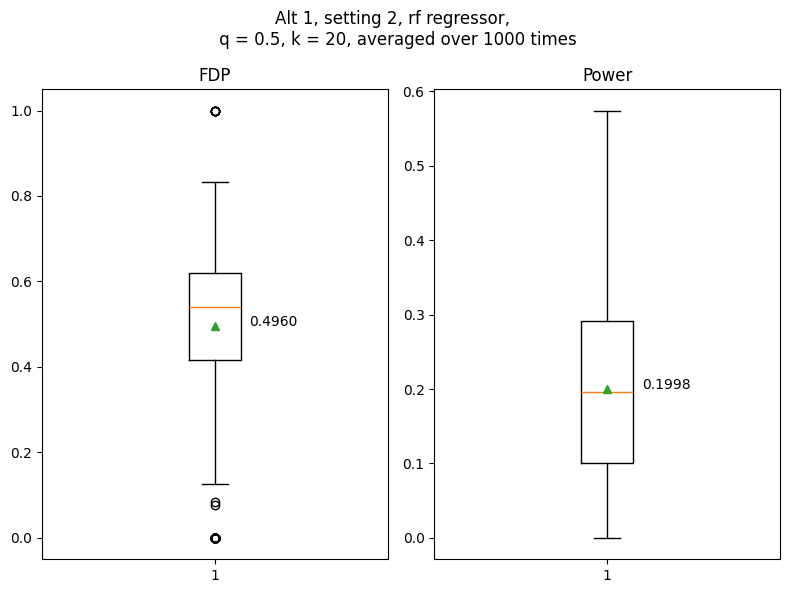

In [51]:
fdps_alt1, powers_alt1 = alt1(2, 'rf', 0.5, 20)

##### Alternative 2.1 - do selection for each dimension and then intersect - fit a different regressor for each dimension

In [ ]:
def alt21(setting, reg, q, k, itr=1000, plot=True):
    fdps_alt21 = []
    powers_alt21 = []

    for i_itr in tqdm(range(itr)):
        sel = set([i for i in range(1000)])

        Xtrain, Ytrain = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)
        Xcalib, Ycalib = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)
        Xtest, Ytest = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)

        for d in range(k):
            if reg == 'rf':
                rf = RandomForestRegressor(n_estimators=100, max_depth=50, max_features=10)
            elif reg == 'oracle':
                rf = OracleRegressorkd(setting)
            
            rf.fit(Xtrain, Ytrain[:, d] > 0)

            Ypred_calib = rf.predict(Xcalib)
                
            # calibration 
            calib_scores_2clip = 1000 * (Ycalib[:, d] > 0) - Ypred_calib                         # BH_clip (with M = 1000)

            Ypred = rf.predict(Xtest) 
            test_scores = -Ypred

            # r_sq = r2_score(Ytest[:, d], Ypred)
            BH_2clip = BH(calib_scores_2clip, test_scores, q / k)
            sel &= set(BH_2clip)

        sel = list(sel)

        true_null = np.sum(np.all(Ytest > 0, axis=1))

        if len(sel) == 0:
            BH_2clip_fdp = 0
            BH_2clip_power = 0
        else:
            BH_2clip_fdp = np.sum(np.any(Ytest[sel] <= 0, axis=1)) / len(sel)
            BH_2clip_power = np.sum(np.all(Ytest[sel] > 0, axis=1)) / true_null if true_null != 0 else 0
        fdps_alt21.append(BH_2clip_fdp)
        powers_alt21.append(BH_2clip_power)

    if plot:
        fig, axs = plt.subplots(ncols = 2, figsize=(8, 6))

        fig.suptitle(f"Alt 2.1, setting {setting}, {reg} regressor, \n q = {q}, k = {k}, averaged over {itr} times")
        axs[0].boxplot(fdps_alt21, showmeans=True)
        axs[0].set_title("FDP")
        axs[0].text(1.1, np.mean(fdps_alt21), f"{np.mean(fdps_alt21):.4f}")
        axs[1].boxplot(powers_alt21, showmeans=True)
        axs[1].set_title("Power")
        axs[1].text(1.1, np.mean(powers_alt21), f"{np.mean(powers_alt21):.4f}")
        fig.tight_layout()
        plt.show()
    return fdps_alt21, powers_alt21

In [ ]:
fdps_alt21, powers_alt21 = alt21(2, 'rf', 0.5, 5)

##### Alternative 2.2 - do selection for each dimension and intersect - use one high-dimensional regressor

In [52]:
def alt22(setting, reg, q, k, itr=1000, plot=True):
    fdps_alt22 = []
    powers_alt22 = []

    for i_itr in tqdm(range(itr)):
        sel = set([i for i in range(1000)])

        Xtrain, Ytrain = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)
        Xcalib, Ycalib = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)
        Xtest, Ytest = gen_data_kd(setting, k=k, n=1000, sig=0.5, covar=0.1, dim=10)

        if reg == 'rf':
            rf = RandomForestRegressor(n_estimators=100, max_depth=50, max_features=10)
        elif reg == 'oracle':
            rf = OracleRegressorkd(setting)
        rf.fit(Xtrain, Ytrain > 0)
        
        Ypred_calib = rf.predict(Xcalib)
        Ypred = rf.predict(Xtest) 

        for d in range(k):            
            # calibration 
            calib_scores_2clip = 1000 * (Ycalib[:, d] > 0) - Ypred_calib[:, d]                         # BH_clip (with M = 1000)

            test_scores = -Ypred[:, d]

            # r_sq = r2_score(Ytest[:, d], Ypred[:, d])
            BH_2clip = BH(calib_scores_2clip, test_scores, q / k)
            sel &= set(BH_2clip)

        sel = list(sel)

        true_null = np.sum(np.all(Ytest > 0, axis=1))

        if len(sel) == 0:
            BH_2clip_fdp = 0
            BH_2clip_power = 0
        else:
            BH_2clip_fdp = np.sum(np.any(Ytest[sel] <= 0, axis=1)) / len(sel)
            BH_2clip_power = np.sum(np.all(Ytest[sel] > 0, axis=1)) / true_null if true_null != 0 else 0
        fdps_alt22.append(BH_2clip_fdp)
        powers_alt22.append(BH_2clip_power)

    if plot:
        fig, axs = plt.subplots(ncols = 2, figsize=(8, 6))

        fig.suptitle(f"Alt 2.2, setting {setting}, {reg} regressor, \n q = {q}, k = {k}, averaged over {itr} times")
        axs[0].boxplot(fdps_alt22, showmeans=True)
        axs[0].set_title("FDP")
        axs[0].text(1.1, np.mean(fdps_alt22), f"{np.mean(fdps_alt22):.4f}")
        axs[1].boxplot(powers_alt22, showmeans=True)
        axs[1].set_title("Power")
        axs[1].text(1.1, np.mean(powers_alt22), f"{np.mean(powers_alt22):.4f}")
        fig.tight_layout()
        plt.show()
    return fdps_alt22, powers_alt22

100%|██████████| 1000/1000 [21:28<00:00,  1.29s/it]


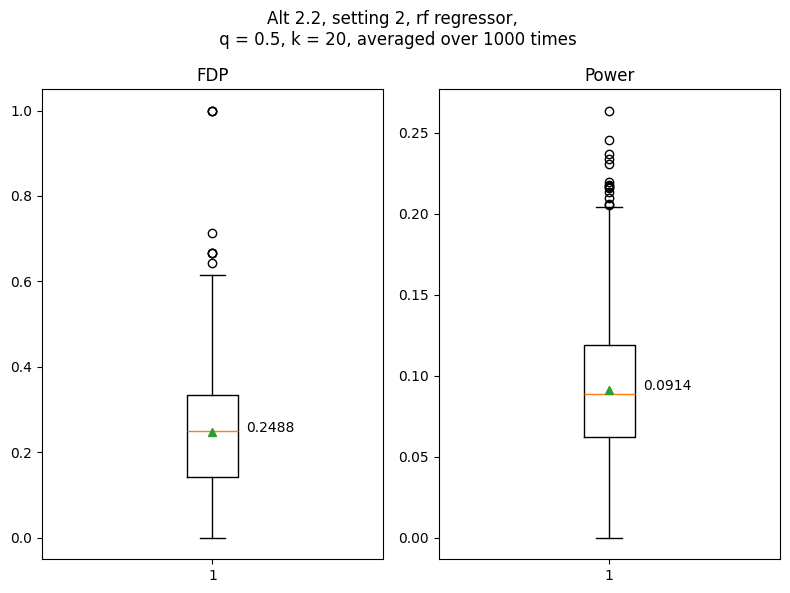

In [53]:
fdps_alt22, powers_alt22 = alt22(2, 'rf', 0.5, 20)